Update: Increase quantity of labeled and unlabeled documents in training data set.

In [231]:
# Import packages and libraries
import numpy as np
import pandas as pd
import random as rnd
import re
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn import metrics

from time import time
from pprint import pprint
from copy import deepcopy
from wordcloud import WordCloud 
from pseudo_model.Semi_EM_NB import Semi_EM_MultinomialNB
from os import path
from PIL import Image

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [232]:
def remove_noise(sentence):
    result = ''
    poster = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stopword_set = set(stopwords.words('english'))
    wordlist = re.sub(r"\n|(\\(.*?){)|}|[!$%^&*#()_+|~\-={}\[\]:\";'<>?,.\/\\]|[0-9]|[@]", ' ', sentence) # remove punctuation
    wordlist = re.sub('\s+', ' ', wordlist) # remove extra space
    wordlist_normal = [poster.stem(word.lower()) for word in wordlist.split()] # restore word to its original form (stemming)
    wordlist_normal = [lemmatizer.lemmatize(word, pos='v') for word in wordlist_normal] # restore word to its root form (lemmatization)
    wordlist_clean = [word for word in wordlist_normal if word not in stopword_set] # remove stopwords
    result = ' '.join(wordlist_clean)
    return result

In [233]:
def cross_validation(clf, data_X, data_y, unlabeled=None, n_folds=5):
    print('=' * 80)
    print("Validation: ")
    print(clf)
    kf = StratifiedKFold(n_splits=n_folds)
    start_time = time()
    train_accuracies= list() # training accuracy
    fold_count = 1
    original_clf = deepcopy(clf)
    for train_ids, valid_ids in kf.split(data_X, data_y):
        cv_clf = deepcopy(original_clf)
        print("Fold # %d" % fold_count)
        fold_count += 1
        train_X, train_y, valid_X, valid_y = data_X[train_ids], data_y[train_ids], data_X[valid_ids], data_y[valid_ids]
        if unlabeled==None:
            cv_clf.fit(train_X, train_y)
        else:
            cv_clf.fit(train_X, train_y, unlabeled)
        pred = cv_clf.predict(valid_X)
        train_accuracies.append(metrics.accuracy_score(valid_y, pred))
    train_time = time() - start_time
    print("Validation time: %0.3f seconds" % train_time)
    print("Average training accuracy: %0.3f" % np.mean(np.array(train_accuracies)))
    return train_accuracies, train_time

In [234]:
def show_topK(classifier, vectorizer, categories, K=10):
    feature_names = np.asarray(vectorizer.get_feature_names())
    nrows, ncols = 2,1 
    fig, axes = plt.subplots(figsize=(50, 40), nrows=nrows, ncols=ncols)
    #d = path.dirname(__file__)
    circle_mask = np.array(Image.open(path.join('/Users/morten/data_science/Text_Analytics/TA_Exam', "circle.png")))
    for i, category in enumerate(categories):
        print(i)
        #print(i,category)
        print(classifier.coef_[i])
        topK = np.argsort(classifier.coef_[i])[-K:]
        text = " ".join(feature_names[topK])
        print("%s: %s" % (category, text))
        wordcloud = WordCloud(background_color="white", mask=circle_mask).generate(text)
        axes[i//ncols, i%ncols].imshow(wordcloud, cmap=plt.cm.cool_r, interpolation='bilinear')
        axes[i//ncols, i%ncols].axis("off")
        axes[i//ncols, i%ncols].set_title(category, fontweight="bold", size=24)
    plt.show()

In [235]:
df = pd.read_excel('data/output/clean_handlabeled_data.xlsx')
df['LABEL'] = df['LABEL'].map({'POS':1,'NEU': 1,'NEG':0,})
X = df['COMMENT'].values
y = df['LABEL'].values

In [236]:
test_size_ratio = 0.2

# Load data set with class labels and split into train and test set
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size_ratio, stratify=y)
print("Training set size: %8d\tTest set size: %8d" % (len(train_X), len(test_X)))

Training set size:      779	Test set size:      195


In [220]:
#count = CountVectorizer(min_df=5, max_df=0.95)
#tfidf = TfidfTransformer(smooth_idf=True,use_idf=False)

In [237]:
# Load data set with class labels and split into train and test set
#test_size_ratio = 0.2
#data_Xy = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
category_names = ['Neg','Pos'] # text names of all categories
#train_X, test_X, train_y, test_y = train_test_split(data_Xy.data, data_Xy.target, test_size=test_size_ratio, stratify=data_Xy.target)
#print("Training set size: %8d\tTest set size: %8d" % (len(train_X), len(test_X)))

In [238]:
# preprocess train and test text data
#train_X_clean = map(remove_noise, train_X)
#test_X_clean = map(remove_noise, test_X)

In [239]:
#X_train_count = count.fit_transform(train_X)

#X_test_count = count.fit_transform(test_X)


#train_vec = tfidf.transform(X_train_count)
#test_vec = tfidf.transform(X_test_count)

In [240]:
# Convert all text data into tf-idf vectors 
vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.95, use_idf =False)
# vectorizer = TfidfVectorizer()
train_vec = vectorizer.fit_transform(train_X)
test_vec = vectorizer.transform(test_X)
print(train_vec.shape, test_vec.shape)

(779, 215) (195, 215)


In [242]:
# Divide train data set into labeled and unlabeled data sets
split_ratio = 0.1 # labeled vs total(labeled+unlabeled)
X_l, X_u, y_l, y_u = train_test_split(train_vec, train_y, train_size=split_ratio, stratify=train_y)
print(X_l.shape, X_u.shape)
print(y_l.shape, y_u.shape)

(77, 215) (702, 215)
(77,) (702,)


/Users/morten/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [243]:
# Cross validation for Naive Bayes classifier 
# using labeled data set only
nb_clf = MultinomialNB(alpha=1e-2)
cross_validation(nb_clf, X_l, y_l)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.022 seconds
Average training accuracy: 0.586


([0.5294117647058824, 0.6666666666666666, 0.8, 0.6, 0.3333333333333333],
 0.021956920623779297)

In [244]:
# Cross validation for semisupervised EM Naive Bayes classifier 
# using both labeled and unlabeled data set
em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False) # semi supervised EM based Naive Bayes classifier
cross_validation(em_nb_clf, X_l, y_l, X_u)



Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.090 seconds
Average training accuracy: 0.573


([0.5294117647058824,
  0.6666666666666666,
  0.6,
  0.5333333333333333,
  0.5333333333333333],
 0.09040093421936035)

In [245]:
# Evaluate original NB classifier using test data set
nb_clf = MultinomialNB(alpha=1e-2).fit(X_l, y_l)
pred = nb_clf.predict(test_vec)
print(metrics.classification_report(test_y, pred, target_names=category_names))
pprint(metrics.confusion_matrix(test_y, pred))
print(metrics.accuracy_score(test_y, pred))

              precision    recall  f1-score   support

         Neg       0.44      0.36      0.40        77
         Pos       0.63      0.70      0.66       118

   micro avg       0.57      0.57      0.57       195
   macro avg       0.54      0.53      0.53       195
weighted avg       0.56      0.57      0.56       195

array([[28, 49],
       [35, 83]])
0.5692307692307692


In [246]:
# Evaluate semi-supervised EM NB classifier using test data set
em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False).fit(X_l, y_l, X_u)
pred = em_nb_clf.predict(test_vec)
print(metrics.classification_report(test_y, pred, target_names=category_names))
pprint(metrics.confusion_matrix(test_y, pred))
print(metrics.accuracy_score(test_y, pred))

              precision    recall  f1-score   support

         Neg       0.38      0.25      0.30        77
         Pos       0.60      0.74      0.66       118

   micro avg       0.54      0.54      0.54       195
   macro avg       0.49      0.49      0.48       195
weighted avg       0.51      0.54      0.52       195

array([[19, 58],
       [31, 87]])
0.5435897435897435


0
[-9.04879174 -5.01349072 -5.03491351 -5.27942934 -5.28813842 -4.903056
 -9.04879174 -4.97512038 -9.04879174 -9.04879174 -5.62115755 -4.7798685
 -4.62261684 -9.04879174 -9.04879174 -9.04879174 -5.09392799 -4.73121514
 -9.04879174 -4.29190246 -3.97519221 -9.04879174 -3.2458562  -4.75871132
 -9.04879174 -9.04879174 -9.04879174 -9.04879174 -5.49734474 -9.04879174
 -4.98612888 -9.04879174 -5.25419602 -9.04879174 -9.04879174 -9.04879174
 -4.89897579 -4.0807459  -4.43549158 -4.053413   -5.4841411  -9.04879174
 -9.04879174 -9.04879174 -4.98453913 -9.04879174 -4.89869955 -9.04879174
 -9.04879174 -9.04879174 -5.32695845 -9.04879174 -4.08112445 -9.04879174
 -9.04879174 -9.04879174 -9.04879174 -4.92813054 -9.04879174 -9.04879174
 -9.04879174 -9.04879174 -4.43367122 -4.1951384  -9.04879174 -9.04879174
 -9.04879174 -9.04879174 -3.12655877 -4.78198108 -3.38957871 -9.04879174
 -5.60919433 -9.04879174 -5.60606995 -9.04879174 -9.04879174 -9.04879174
 -6.10855819 -9.04879174 -5.2852226  -5.60606995 -9.

IndexError: too many indices for array

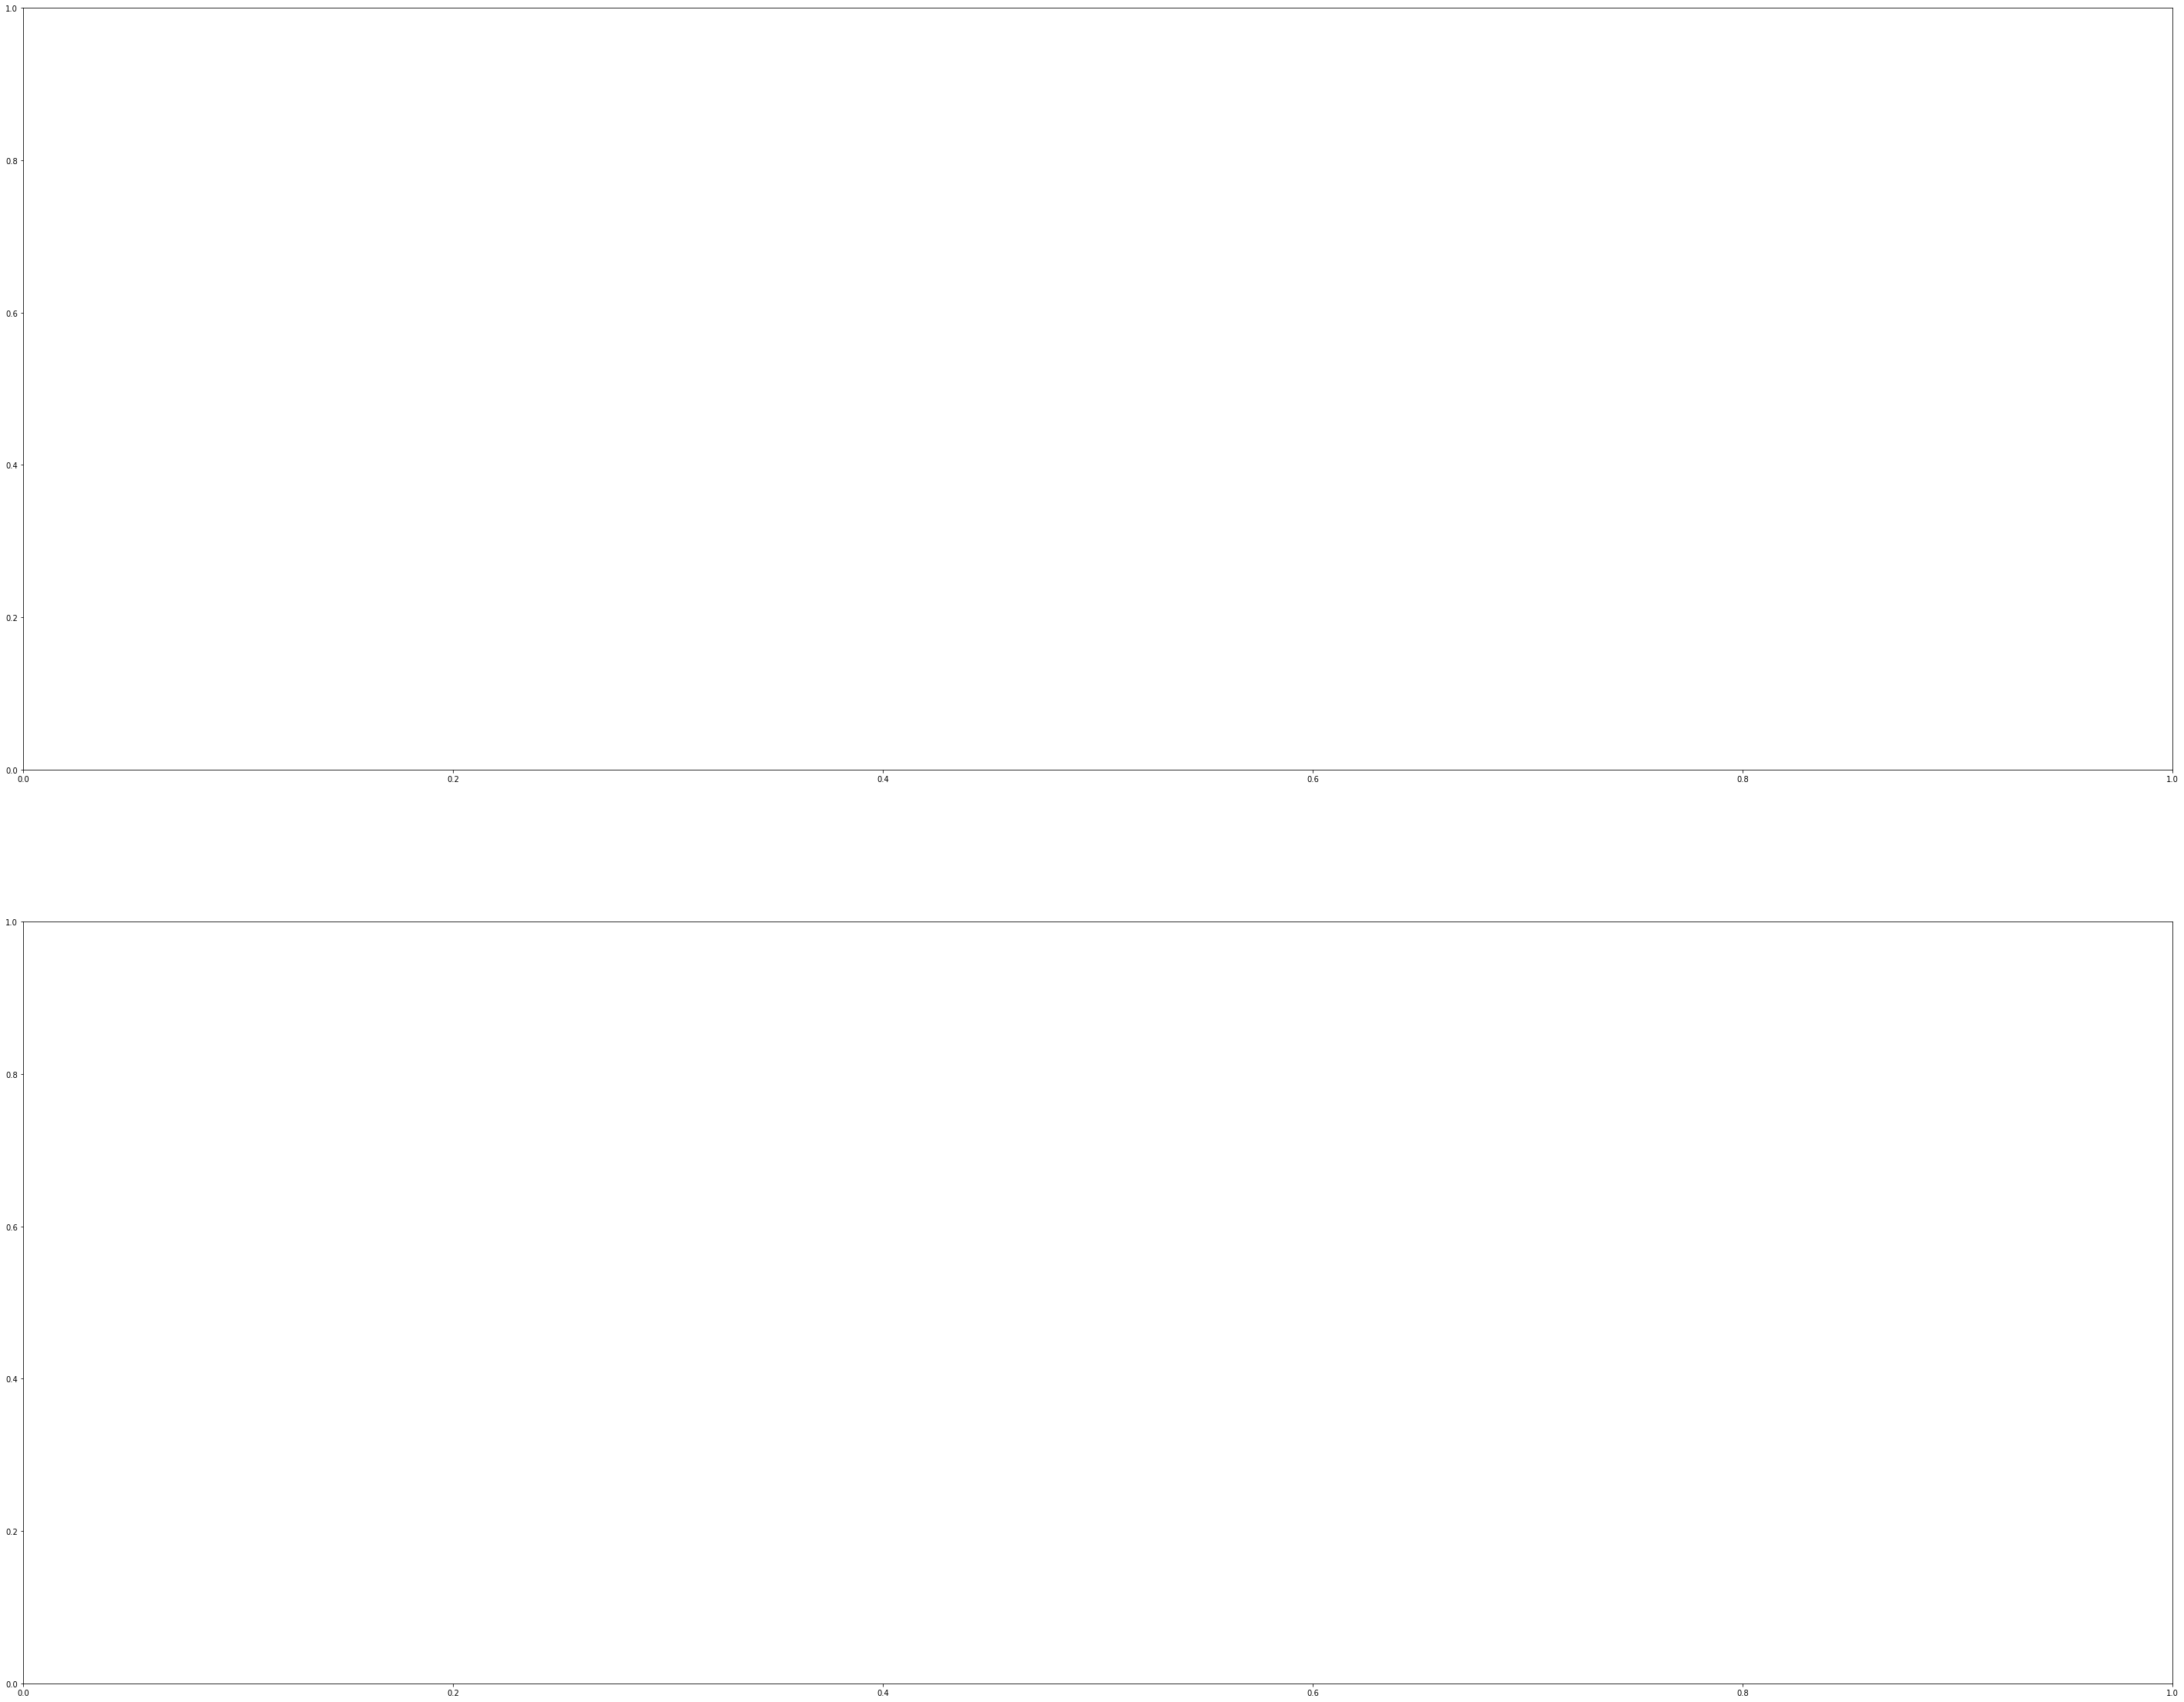

In [230]:
show_topK(nb_clf, vectorizer, category_names, K=20) # keywords for each class by original NB classifier

In [ ]:
show_topK(em_nb_clf, vectorizer, category_names, K=30) # keywords for each class by semisupervised EM NB classifier